In [1]:
%load_ext autoreload
%autoreload 2

## Fist, get the HTML

In [2]:
#import requests
#page = requests.get('https://pycon.jp/2014/schedule/talks/list/')
#page_content = page.text
page_content = open('samples/PyData Berlin 2015 | May 29-30.speakers.html').read()

We can list the repeating tagpaths, with or without classes or HTML IDs:

In [3]:
from collections import Counter
from sketchtml.repeats import TagPathClustering


clustering = TagPathClustering(page_content,
                               with_id=False,
                               with_classes=True,
                               strip_digits=False)
clustering._build_tagpaths()

for tp, cnt in Counter(clustering.tagpaths).most_common():
    if cnt > 1:
        print('({:3d}) {}'.format(cnt, tp))

( 72) /html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/div.speaker__abstract/div.speaker__abstract__text/br
( 24) /html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker
( 24) /html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-thumb
( 24) /html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-thumb/img
( 24) /html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content
( 24) /html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/a.anchor
( 24) /html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/h3
( 24) /html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/div.small
( 24) /html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/strong
( 24) /html/body/div.row/div.columns.l

## Clustering of tagpaths

Perform spectral clustering using the methom from ["Extracting Data Records from the Web Using Tag Path Clustering", 2009](http://www2009.wwwconference.org/proceedings/pdf/p981.pdf).

> Miao, Gengxin & Tatemura, Junichi & Hsiung, Wang-Pin & Sawires, Arsany & Moser, Louise. (2009).
> **Extracting data records from the Web using tag path clustering**. ACM WWW. 981-990. 10.1145/1526709.1526841.

In [4]:
clusters = clustering.clusters()

## Plotting tagpaths "signals" can help chosing better `with_classes`, `with_ids` parameters

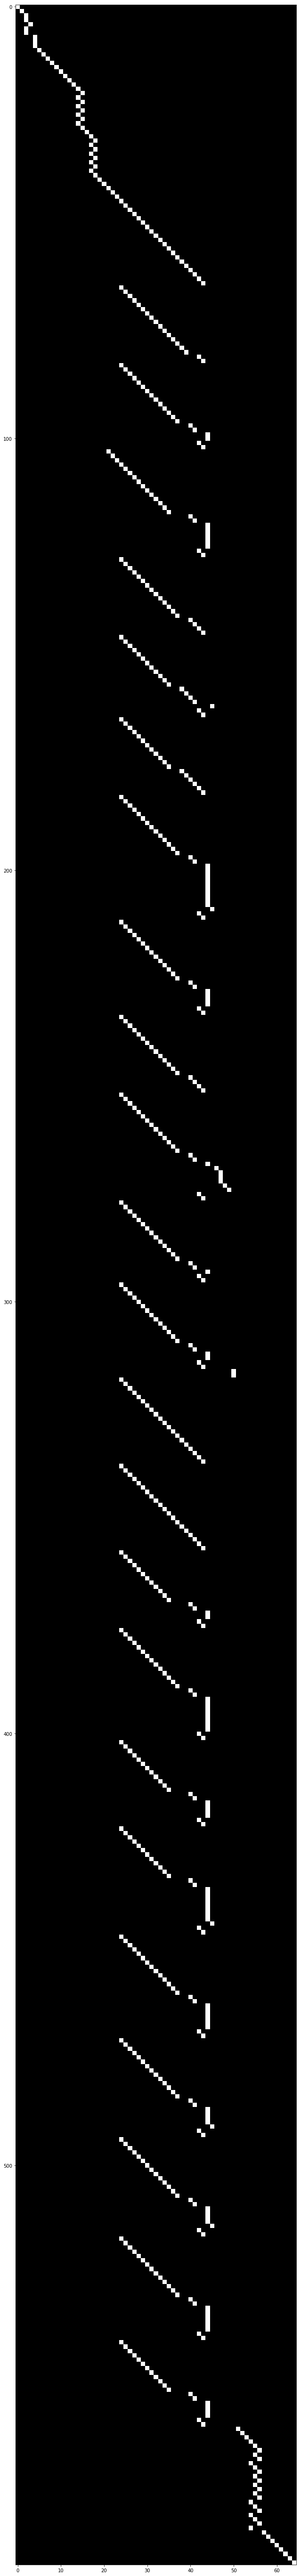

In [5]:
clustering.simhelper.plot_signals()

In [6]:
from pprint import pprint as pp

pp(clusters)

defaultdict(<class 'list'>,
            {0: ['/html/body/div.row/div.columns.large-10/a',
                 '/html/body/div.row/div.columns.large-10/a/h1',
                 '/html/body/div.row/div.columns.large-10/div.speaker-container'],
             1: ['/html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/div.speaker__abstract',
                 '/html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/div.speaker__abstract/div.speaker__abstract__text',
                 '/html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/div.speaker__bio',
                 '/html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/div.speaker__bio/div.speaker__bio__text',
                 '/html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/div.speaker__bio/div.speaker__bio__text/br'],
             2: ['/

Let's build a trie to reconstruct the layout from a tagpath list (from one or more clusters or a chosen subset of tagpaths)

In [7]:
from functools import partial
from typing import Tuple
from pprint import pformat

_node_repr = partial(TagPathClustering.node_repr,
                             with_classes=True,
                             with_id=False,
                             with_attr_names=False,
                             strip_digits=False)

# This if borrowed from https://towardsdatascience.com/implementing-a-trie-data-structure-in-python-in-less-than-100-lines-of-code-a877ea23c1a1

class TrieNode(object):
    """
    Our trie node implementation. Very basic. but does the job
    """
    
    def __init__(self, char_repr):
        self.char_repr = char_repr
        self.elements = set()
        self.children = []
        # Is it the last character of the word.`
        self.word_finished = False
        # How many times this character appeared in the addition process
        self.counter = 1

def add(root, word):
    """
    Adding a word in the trie structure
    """
    node = root
    #print('Root: {}, Word: {}'.format(root, word))
    for char in word:
        char_repr = _node_repr(char)
        #print('Char: {}'.format(char_repr))
        found_in_child = False
        # Search for the character in the children of the present `node`
        for child in node.children:
            if child.char_repr == char_repr:
                # We found it, increase the counter by 1 to keep track that another
                # word has it as well
                child.counter += 1
                # And point the node to the child that contains this char
                node = child
                found_in_child = True
                #print('Child found.')
                node.elements.add(char)
                break
        # We did not find it so add a new chlid
        if not found_in_child:
            new_node = TrieNode(char_repr)
            new_node.elements.add(char)
            node.children.append(new_node)
            # And then point node to the new child
            node = new_node
            #print('Child NOT found. Creating new TrieNode({})'.format(char))
    # Everything finished. Mark it as the end of a word.
    node.word_finished = True

To help chose the clusters we need, we can print out some of the text data for each tagpath in each cluster.

In [8]:
from pprint import pprint

for n, cluster in sorted(clusters.items()):
    if len(cluster) < 3:
        continue

    print('---- Cluster #{} ----'.format(n))
    for tp in sorted(cluster, key=lambda tp: tp.split('/')):
        to_print = []
        try:
            for nodepath in clustering.tagpath_nodes[tp][:10]:
                node = nodepath[-1]
                e = node.element
                texts = [s.strip() for s in e.xpath('./text()[normalize-space()]')]
                attribs = {k: v for k, v in e.attrib.items() if k not in ['class']}
                t = ' '.join(texts)
                #if t or attribs:
                if t:
                    to_print.append((node.doc_order, t, attribs))
            if to_print:
                print('---\n'+tp)
                for e in to_print:
                    print(e)
                print()
        except Exception as e:
            print(str(e))
            pass

---- Cluster #0 ----
---
/html/body/div.row/div.columns.large-10/a/h1
(51, 'Keynotes', {})
(115, 'Speakers', {})

---- Cluster #1 ----
---
/html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/div.speaker__abstract/div.speaker__abstract__text
(71, 'When it comes to ownership, the internet is broken. Artists, designers, and other creatives can share their work easily on the internet, but keeping it as "theirs" and get fairly compensated has proven difficult. How do you "own" something when bits can be copied freely? It turns out that visionaries of hypertext foresaw this issue in the 60s. They even proposed systems to handle this. However, those systems were too complex and hard to build. By the early 90s, the simpler WWW had won, but unfortunately in its simplicity it left out attribution to owners. We ask a new question: can we retrofit the internet for ownership? It turns out the answer is yes, with the help of python-powered big data, machine 

Clusters 1 and 2 look interesting

In [12]:
root = TrieNode('')
nodelists = clustering.tagpath_nodes
tps = []
for i in [1, 2]:
    for tp in clusters[i]:
        tps.append(tp)
tps

['/html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/div.speaker__abstract',
 '/html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/div.speaker__abstract/div.speaker__abstract__text',
 '/html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/div.speaker__bio',
 '/html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/div.speaker__bio/div.speaker__bio__text',
 '/html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/div.speaker__bio/div.speaker__bio__text/br',
 '/html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker',
 '/html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content',
 '/html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker/div.speaker-content/a.anchor',
 '/html/body/div.row/div.columns.large-10/div.speaker-c

Now let's insert them into the trie:

In [14]:
for tp in tps:
    steps = tp.lstrip('/').split('/')
    for nl in nodelists[tp][:]:
        add(root, nl)

In [15]:
def layout(node, summary=True):
    return dict(
        tag=node.char_repr if node.char_repr else node.char_repr,
        element=len(set(node.elements)) if summary else set(node.elements),
        children=[layout(c, summary=summary) for c in node.children],
        word_finished=node.word_finished
    )

If we check the general structure of the trie, we can notice that some levels only have 1 child.

In [17]:
layout(root)

{'tag': '',
 'element': 0,
 'children': [{'tag': 'html',
   'element': 1,
   'children': [{'tag': 'body',
     'element': 1,
     'children': [{'tag': 'div.row',
       'element': 1,
       'children': [{'tag': 'div.columns.large-10',
         'element': 1,
         'children': [{'tag': 'div.speaker-container',
           'element': 2,
           'children': [{'tag': 'div.speaker',
             'element': 24,
             'children': [{'tag': 'div.speaker-content',
               'element': 24,
               'children': [{'tag': 'div.speaker__abstract',
                 'element': 23,
                 'children': [{'tag': 'div.speaker__abstract__text',
                   'element': 23,
                   'children': [{'tag': 'ul',
                     'element': 1,
                     'children': [{'tag': 'li',
                       'element': 3,
                       'children': [],
                       'word_finished': True}],
                     'word_finished': False}],
    

We can collapse those branches:

In [18]:
def collapse(trienode):
    for c in trienode.children:
        collapse(c)
    if len(trienode.children) == 1 and not trienode.word_finished:
        trienode.char_repr += '/'+trienode.children[0].char_repr
        trienode.elements = trienode.children[0].elements
        
        trienode.children = trienode.children[0].children

In [19]:
collapse(root)
pp(layout(root))

{'children': [{'children': [{'children': [{'children': [{'children': [],
                                                         'element': 3,
                                                         'tag': 'ul/li',
                                                         'word_finished': False}],
                                           'element': 23,
                                           'tag': 'div.speaker__abstract__text',
                                           'word_finished': True}],
                             'element': 23,
                             'tag': 'div.speaker__abstract',
                             'word_finished': True},
                            {'children': [{'children': [{'children': [],
                                                         'element': 2,
                                                         'tag': 'br',
                                                         'word_finished': True}],
                                       

The trie also keeps references to individual HTML nodes, with their document order so that we can re-build the data hierarchy:

In [20]:
layout(root, summary=False)

{'tag': '/html/body/div.row/div.columns.large-10/div.speaker-container/div.speaker',
 'element': {Node(tag='div', doc_order=54, child_position=1, attribs={'class': 'speaker'}, element=<Element div at 0x7f2ea515b6c8>),
  Node(tag='div', doc_order=75, child_position=2, attribs={'class': 'speaker'}, element=<Element div at 0x7f2ea5159308>),
  Node(tag='div', doc_order=94, child_position=3, attribs={'class': 'speaker'}, element=<Element div at 0x7f2ea515d7c8>),
  Node(tag='div', doc_order=118, child_position=1, attribs={'class': 'speaker'}, element=<Element div at 0x7f2ea515c488>),
  Node(tag='div', doc_order=141, child_position=2, attribs={'class': 'speaker'}, element=<Element div at 0x7f2ea515f6c8>),
  Node(tag='div', doc_order=160, child_position=3, attribs={'class': 'speaker'}, element=<Element div at 0x7f2ea5161a88>),
  Node(tag='div', doc_order=180, child_position=4, attribs={'class': 'speaker'}, element=<Element div at 0x7f2ea51573c8>),
  Node(tag='div', doc_order=199, child_positio

## Re-creating data hierarchy

Below is the most interesting bit: how to re-create a dict/JSON document from repeating tagpaths.

Using the trie, from the root of the tree, we loop over all HTML elements of a trie node, and recursively collect data from its children:

In [23]:
from collections import defaultdict
from operator import itemgetter
from lxml.html import tostring


def hydrate(node, docorder_min, docorder_max=None, include_html=False):
    elements = sorted(set(node.elements), key=lambda n: n.doc_order)
    output = []

    for i, element in enumerate(elements, start=1):
        
        # filter out elements that are not within the parent document order range
        if not (docorder_min < element.doc_order):
            continue
        if (docorder_max is not None) and (element.doc_order > docorder_max):
            continue
        
        # here's where you extract data from the element
        # 1. node representation including tag and classes can tell us a bit about what it's about
        # 2. document order is purely informational
        # 3. child text nodes usually contain much of the information we want
        # 4. element attributes also can be useful (URL, data-* etc.)
        e = {'tag': _node_repr(element),
             '_doc_order': element.doc_order}
        
        # textual information
        _t = list(filter(bool, [t.strip() for t in element.element.xpath('./text()[normalize-space()]')]))
        if _t:
            e['text'] = _t[0] if len(_t) == 1 else _t
        _html = tostring(element.element, encoding='unicode')
        if _html:
            e['html'] = _html
            
        _attrib = dict(element.element.attrib)
        if 'class' in _attrib:
            _attrib.pop('class')
        if _attrib:
            e['_attr'] = _attrib
        
        # loop through sub-nodes that are between the current node and the next one
        # Warning: recursivity!
        _order_min = element.doc_order
        if i < len(elements):
            _order_max = elements[i].doc_order
        else:
            _order_max = None
        children = list(filter(bool, [c for child in node.children
                                      for c in hydrate(child, _order_min, _order_max)]))
        if children:
            e['children'] = sorted(children, key=itemgetter('_doc_order'))
        
        # if there's not "valuable" information, might as well skip the element
        if 'children' not in e and not(any(e.get(k) for k in ['text', '_attr'])):
            continue

        output.append(e)
        
    return sorted(output, key=itemgetter('_doc_order'))

output = hydrate(root, 0)
pp(output)

[{'_doc_order': 54,
  'children': [{'_doc_order': 55,
                'children': [{'_attr': {'alt': 'Trent McConaghy',
                                        'src': 'static/assets/speaker/trent-mcconaghy.jpg'},
                              '_doc_order': 56,
                              'html': '<img '
                                      'src="static/assets/speaker/trent-mcconaghy.jpg" '
                                      'alt="Trent McConaghy">\n'
                                      '  ',
                              'tag': 'img'}],
                'html': '<div class="speaker-thumb">\n'
                        '    <img '
                        'src="static/assets/speaker/trent-mcconaghy.jpg" '
                        'alt="Trent McConaghy">\n'
                        '  </div>\n'
                        '  ',
                'tag': 'div.speaker-thumb'},
               {'_doc_order': 57,
                'children': [{'_attr': {'id': 'mcconaghy_0'},
                       

The output data seems to present all the data we'd need for something like PyVideo.org.

Let's just save for further processing.

In [24]:
import json

JSON_FORMAT_KWARGS = {
    'indent': 2,
    'separators': (',', ': '),
    'sort_keys': True,
}
with open('pydata-berlin-2015.speakers.json', 'w') as fp:
    json.dump(output, fp, **JSON_FORMAT_KWARGS)
    fp.write("\n")

## Is there a way to automatically chose clusters?

Spectral clustering does not always give the "best" results. It may be due to the similarity function, or some other parameters, I don't know yet really.

Below is a just to see if hierarchical clustering of tagpaths would do a better job.

In [25]:
simhelper = clustering.simhelper

In [27]:
from itertools import zip_longest, combinations
from collections import Counter

import numpy as np

tagpaths = [
    tp for tp, cnt in Counter(clustering.tagpaths).most_common()
    if cnt > 1
]

l = len(tagpaths)
matrix = np.zeros((l, l))

for a, b in combinations(tagpaths, 2):
    ia, ib = tagpaths.index(a), tagpaths.index(b)
    try:
        matrix[ia, ib] = 1 - simhelper.similarity(a, b, epsilon=10)
    except:
        matrix[ia, ib] = 1
    matrix[ib, ia] = matrix[ia, ib]
    matrix[ia, ia] = 0
    matrix[ib, ib] = 0

In [28]:
from sklearn.cluster import AgglomerativeClustering

clustering2 = AgglomerativeClustering(n_clusters=l, affinity='precomputed', linkage='average')

clustering2.fit_predict(matrix)

array([35, 29, 26, 30, 18, 31, 25, 32, 24, 33, 23, 34, 15, 17, 27, 28, 22,
       13, 21, 11, 16, 10,  8, 20, 19,  9, 14,  6, 12,  7,  5,  4,  3,  1,
        2,  0])

In [29]:
# Authors: Mathew Kallada
# License: BSD 3 clause
"""
=========================================
Plot Hierarachical Clustering Dendrogram 
=========================================

This example plots the corresponding dendrogram of a hierarchical clustering
using AgglomerativeClustering and the dendrogram method available in scipy.
"""

import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

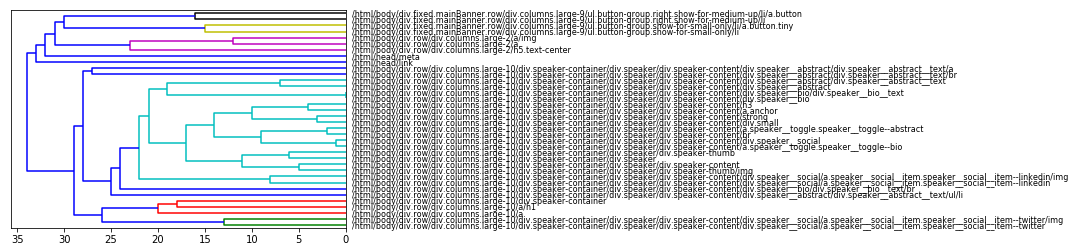

In [30]:
ax = plt.plot()
plot_dendrogram(clustering2, labels=tagpaths, orientation='left'
                , leaf_font_size=8
               )